# Introduction

### Discuss the business problem and who would be interested in this project.

In this project, I'll be exploring a problem near and dear to my heart: where to go in New York to find pizza and coffee. I'll find the nieghborhoods where each is most common, pick a couple neighborhoods that have a lot of both. I'll also explore the relationship between neighborhoods that have a lot of coffee and those that have a lot of pizza. This will answer the question of whether I can expect a lot of coffee shops in a neighborhood that has a lot of pizza









 # Data
### Describe the data that will be used to solve the problem and the source of the data.

We'll use two main data sources for this project:

One is a CSV file provided earlier in this course that has the lat/long data and names of all the neighborhoods in New York

The other is the Foursquare API, which will provide names and locations of all the pizza and coffee shops in New York, according to the Foursquare databas



## Methodology

#### First, we'll import the libraries we will need. 

In [4]:
#import libraries needed. 

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.21.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

#### Now let's get the names of neighborhoods and associated data fromt the data set used earlier in the course

In [5]:
#Download NY neighborhood data
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')


Data downloaded!


In [6]:
with open('newyork_data.json') as json_data:
   # neighborhoods_data = json.load(json_data)
    results = json.load(json_data)

In [7]:
neighborhoods_data = results['features']
neighborhoods_data[0]


{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [8]:
#put into dataframe

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

neighborhoods

,Borough,Neighborhood,Latitude,Longitude


#### Now, we'll put the neighborhood data into a data frame

In [9]:

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### First Coffee
#### We'll be getting data from Foursquare about Coffee and Pizza, but we'll start with coffee


In [11]:
CLIENT_ID = 'HXKX3CMIVHB1K555GJ1ZKKRWG55HHBDAPCCYYZWWLZW2OOT0' # your Foursquare ID
CLIENT_SECRET = '0HF44O5FHDVR5OOZQSVATBATKSWZFLHKUCE1L1OWSQ1TX0JD' # your Foursquare Secret
VERSION = '20190205' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: HXKX3CMIVHB1K555GJ1ZKKRWG55HHBDAPCCYYZWWLZW2OOT0
CLIENT_SECRET:0HF44O5FHDVR5OOZQSVATBATKSWZFLHKUCE1L1OWSQ1TX0JD


In [12]:
# type your answer here
#may be able to delete this because of the function defined further below
LIMIT = 500
radius = 500
category = '4bf58dd8d48988d16d941735,4bf58dd8d48988d1e0931735' #query cooresponding to 'coffee' in foursquare API
query = 'coffee shop' #using additional queries and intent to eliminate restaurants that also serve coffee
intent = 'coffee'
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&category={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_lat, neighborhood_lon, VERSION, radius, LIMIT, category)
url


'https://api.foursquare.com/v2/venues/search?client_id=HXKX3CMIVHB1K555GJ1ZKKRWG55HHBDAPCCYYZWWLZW2OOT0&client_secret=0HF44O5FHDVR5OOZQSVATBATKSWZFLHKUCE1L1OWSQ1TX0JD&ll=40.61731079252983,-74.08173992211962&v=20190205&radius=500&limit=500&category=4bf58dd8d48988d16d941735,4bf58dd8d48988d1e0931735'

In [13]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e3c3756216785001b161dee'},
 'response': {'venues': [{'id': '4dd66322d22d38ef42cd73d3',
    'name': 'MTA Bus - Vanderbilt Av & Osgood Av (S76)',
    'location': {'address': 'Vanderbilt Ave',
     'crossStreet': 'at Osgood Ave',
     'lat': 40.61780856258315,
     'lng': -74.08111056561337,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.61780856258315,
       'lng': -74.08111056561337}],
     'distance': 76,
     'postalCode': '10304',
     'cc': 'US',
     'city': 'Staten Island',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['Vanderbilt Ave (at Osgood Ave)',
      'Staten Island, NY 10304',
      'United States']},
    'categories': [{'id': '52f2ab2ebcbc57f1066b8b4f',
      'name': 'Bus Stop',
      'pluralName': 'Bus Stops',
      'shortName': 'Bus Stop',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/busstation_',
       'suffix': '.png'},
      'primary': True}],
    'refer

In [16]:
def getNearbyCoffee(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&category={}&query={}&intent={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            category,
            query,
            intent
        )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
#Now write the code to run the above function on each neighborhood and create a new dataframe called manhattan_venues.
#change this later to include all 5 boroughs
#change to be 'restaurants' not 'venues'
neighborhood_coffees = getNearbyCoffee(names= neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )


In [23]:
print(neighborhood_coffees.shape)
neighborhood_coffees.head(10)

(2363, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
1,Eastchester,40.887556,-73.827806,Dunkin',40.885384,-73.828099,Donut Shop
2,Kingsbridge,40.881687,-73.902818,Mon Amour Coffee & Wine,40.885009,-73.900332,Coffee Shop
3,Kingsbridge,40.881687,-73.902818,Gold Mine Cafe,40.878916,-73.904698,Café
4,Kingsbridge,40.881687,-73.902818,Dunkin',40.879308,-73.905066,Donut Shop
5,Kingsbridge,40.881687,-73.902818,Sugarboy Bakery Cafe,40.877948,-73.902860,Bakery
6,Kingsbridge,40.881687,-73.902818,Dunkin',40.884442,-73.900185,Donut Shop
7,Kingsbridge,40.881687,-73.902818,gold mine donut shop,40.878955,-73.904475,Donut Shop
8,Kingsbridge,40.881687,-73.902818,Kingsbridge Donut Shop,40.879735,-73.906387,Donut Shop
9,Marble Hill,40.876551,-73.910660,Starbucks,40.877531,-73.905582,Coffee Shop


In [24]:
#get count of coffeeshops by neighborhood
neighborhood_cafes = neighborhood_coffees.drop(['Neighborhood Latitude', 'Neighborhood Longitude','Venue Latitude','Venue Longitude' ], axis=1)
neighborhood_cafes1= neighborhood_cafes.groupby('Neighborhood').count()

#rank them and get the top 10
nc_ranked = neighborhood_cafes1.sort_values(by=['Venue'], ascending = False)
nc_ranked.head(10)



,Venue,Venue Category
Neighborhood,,
Midtown,100,100
Little Italy,84,84
Chinatown,77,77
Greenwich Village,70,70
Soho,67,67
Financial District,62,62
North Side,53,53
East Village,51,51
Midtown South,51,51


#### These are our top 10 neighborhoods for coffee shops. Let's get top 10 neighborhoods for pizza and compare.

### PIZZA!

#### Now that we found the top coffee neighborhoods, let's find where the neighborhoods with the most Pizza are.


In [18]:
# Reset URL parameters for pizza
LIMIT = 500
radius = 500
category = '4bf58dd8d48988d1ca941735' #category cooresponding to 'Pizza place' in foursquare API
query = 'pizza' #using additional queries and intent to eliminate restaurants that also serve coffee
p_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&category={}&query={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_lat, neighborhood_lon, VERSION, radius, LIMIT, category, query)
p_url

'https://api.foursquare.com/v2/venues/search?client_id=HXKX3CMIVHB1K555GJ1ZKKRWG55HHBDAPCCYYZWWLZW2OOT0&client_secret=0HF44O5FHDVR5OOZQSVATBATKSWZFLHKUCE1L1OWSQ1TX0JD&ll=40.61731079252983,-74.08173992211962&v=20190205&radius=500&limit=500&category=4bf58dd8d48988d1ca941735&query=pizza'

In [19]:
results = requests.get(p_url).json()
results

{'meta': {'code': 200, 'requestId': '5e3c39409fcb92001ba58342'},
 'response': {'venues': [{'id': '4f32053619833175d60a6206',
    'name': 'Napoli Pizza',
    'location': {'address': '487 Vanderbilt Ave',
     'lat': 40.614568,
     'lng': -74.085812,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.614568,
       'lng': -74.085812}],
     'distance': 460,
     'postalCode': '10304',
     'cc': 'US',
     'city': 'Staten Island',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['487 Vanderbilt Ave',
      'Staten Island, NY 10304',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d1ca941735',
      'name': 'Pizza Place',
      'pluralName': 'Pizza Places',
      'shortName': 'Pizza',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1581005098',
    'hasPerk': False}]}}

In [20]:
def getNearbyPizza(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&category={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            category,
            query
        )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'] 
           # v['venue']['categories'][0]['name']
        )for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude'
                  #'Venue Category'
                            ]
    
    return(nearby_venues)

In [21]:
neighborhood_pizza= getNearbyPizza(names= neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )


In [22]:
print(neighborhood_pizza.shape)
neighborhood_pizza.head(10)

(1988, 6)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
0,Wakefield,40.894705,-73.847201,Louis Pizza,40.898399,-73.848810
1,Wakefield,40.894705,-73.847201,Lj Pizza,40.890927,-73.849010
2,Co-op City,40.874294,-73.829939,Capri II Pizza,40.876374,-73.829940
3,Co-op City,40.874294,-73.829939,Bartow Pizza,40.870280,-73.828611
4,Co-op City,40.874294,-73.829939,Kennedy Fried Chicken & Pizza,40.876651,-73.829092
5,Eastchester,40.887556,-73.827806,Mario's Pizza,40.888628,-73.831260
6,Kingsbridge,40.881687,-73.902818,Kingsbridge Social Club,40.884545,-73.901964
7,Kingsbridge,40.881687,-73.902818,Sam's Pizza,40.879435,-73.905859
8,Kingsbridge,40.881687,-73.902818,Broadway Pizza & Pasta,40.878822,-73.904494
9,Kingsbridge,40.881687,-73.902818,Little Caesars Pizza,40.880002,-73.904140


In [74]:
#get count of pizza places by neighborhood
neighborhood_pizzas = neighborhood_pizza.drop(['Neighborhood Latitude', 'Neighborhood Longitude','Venue Latitude','Venue Longitude' ], axis=1)
neighborhood_pizzas1= neighborhood_pizzas.groupby('Neighborhood').count()

#rank them and get the top 10
np_ranked = neighborhood_pizzas1.sort_values(by=['Venue'], ascending = False)
np_ranked.head(10)


,Venue
Neighborhood,
Midtown South,51
Midtown,49
Noho,47
Financial District,40
Civic Center,40
Chinatown,39
Murray Hill,38
Soho,38
East Village,36


#### Now let's compare neighborhoods with a lot of pizza places to neighborhoods with a lot of coffee shops

In [64]:
# merge data frames and rename columns

np_ranked_new = np_ranked.rename(columns={"Venue": "Count: Pizza Places"})

#np_ranked_new.head()
nc_ranked_new = nc_ranked.rename(columns={"Venue": "Count: Coffee Shops"})

nc_ranked_new = nc_ranked_new.drop(columns={"Venue Category"})
#nc_ranked_new


cp_df = pd.concat([np_ranked_new, nc_ranked_new], axis=1, sort=False)
cp_df1 = cp_df.fillna(0)
cp_df1.head()

#cp_df = cp_df.dropna(inplace=True)


,Count: Pizza Places,Count: Coffee Shops
Midtown South,51.0,51.0
Midtown,49.0,100.0
Noho,47.0,41.0
Financial District,40.0,62.0
Civic Center,40.0,48.0


In [60]:
#import matplotlib
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style



# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0



Matplotlib version:  3.0.2


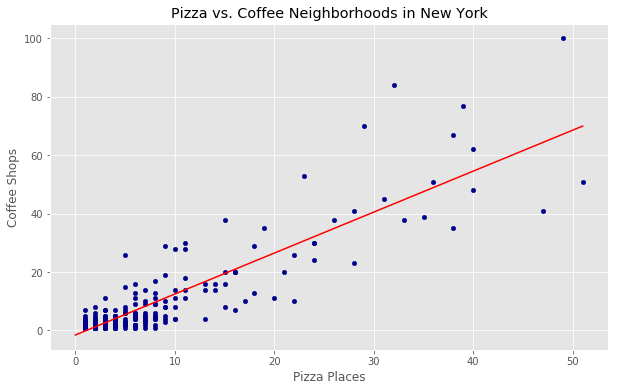

In [67]:

#scatter plot to show neighborhoods with a lot of coffee shops and those with a lot of pizza places


x = cp_df1['Count: Pizza Places']      # year on x-axis
y = cp_df1['Count: Coffee Shops']     # total on y-axis
fit = np.polyfit(x, y, deg=1)
#Create scatter plot
cp_df.plot(kind='scatter', x = 'Count: Pizza Places', y= 'Count: Coffee Shops', figsize=(10, 6), color='darkblue')
plt.plot(x, fit[0] * x + fit[1], color='red') # recall that x is the Years
plt.title('Pizza vs. Coffee Neighborhoods in New York')
plt.xlabel('Pizza Places')
plt.ylabel('Coffee Shops')


plt.show()


In [71]:
from scipy import stats

In [70]:
#run correlation, least squares etc. 

cp_df1.corr()


,Count: Pizza Places,Count: Coffee Shops
Count: Pizza Places,1.000000,0.882736
Count: Coffee Shops,0.882736,1.000000


In [73]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

The Pearson Correlation Coefficient is nan  with a P-value of P = 1.0


# Results 


We can see that there are a lot of places to get coffee and pizza in New York. 

Many of the top coffee neighborhoods also have  a lot of Pizza. Some places where you can get both coffee and pizza include:
Midtown 
Midtown South
The Financial District
Soho

When we plot the relationship between neighbrhoods with a lot of coffee and those with a lot of pizza, we see that those variables predict each other fairly well. 

The correlation between the two variables is  0.88!

Therefore if we find ourselves in a neighborhood we don't know in New York and we see a lot of coffee, we can be fairly certain that we will be able to find pizza if we get hungry!



# Discussion
### Discuss any observations you noted and any recommendations you can make based on the results.

Where as we have determined the best coffee and pizza neighborhoods based on sheer volume, there is more analysis we can do to get a deeper understanding of coffee and pizza in New York

For example, we could look at other types of venues to see if they have predictive power on the prevalence of pizza or coffee in a neighborhood. 

Our analysis also failed to take into account any data on pizza and coffee quality. It could be the case that we have predicted nieghborhoods that have a lot of coffee and a lot of pizza, but that these neighborhoods have largely bad or mediocre pizza. It may be the case, and I strongly suspect that this is the case, that if we go to midtown, we'll have lots of options for pizza and coffee but that they will be largely mediocre. This definitely warrants further analysis. 

Another thing we could investigate in the future is whether the existing neighborhoods are actually good ways to divide New York in terms of coffee and pizza prediction. We could use K-square or other techniques to segment New York geographically around clusters of high pizza and coffee density. 



# Conclusion


We got some excellent data and insights about coffee and pizza in New York. This analysis is a good starting point in exploring the food & drink scene in New York, starting with two of my favorite things.

We also learned that if we see coffee in New York, there is a good chance there is pizza near by. That's practical knowledge I hope to put to use soon!

As we discussed in the 'Discussion' section, there is still more to learn. We're looking forward to exploring more about pizza and coffee in New York in the future. 

